# 02 - Latent Semantic Analysis (LSA)
This notebook performs Latent Semantic Analysis on the governance data set. It assumes the data was cleaned and placed in the cache by the "Explore the Governance Data Set" notebook.

We start out by replicating the steps that Joshua Cook shows in his [Introduction to Latent Semantic Analysis](https://www.youtube.com/playlist?list=PLroeQp1c-t3qwyrsq66tBxfR6iX6kSslt) youtube series. Although we follow his examples, we renamed a few things, graphed some of it and wrap results in a Pandas data frame for readability and easy handling. From there we apply the same to out governance data set. It starts off pretty similar to our earlier notebook that performs a TF-IDF analysis of the documents.

---
## Dependencies and Imports
Here we import the libraries we need to perform our analysis.

In [2]:
!pip install scikit-learn pandas seaborn graphviz

In [3]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import seaborn as sns
CMAP_VLAG = sns.color_palette("vlag", as_cmap=True)
print(f"seaborn=={sns.__version__}")

from graphviz import __version__ as graphviz__version__
print(f"graphviz=={graphviz__version__}")
from graphviz import Source as dot_graph


python==3.10.8
scikit-learn==1.1.3
pandas==1.4.4
matplotlib==3.5.3
seaborn==0.12.0
graphviz==0.20.1


---
## Replicate Joshua Cook's Examples
Joshua starts with a trivial set of documents, represented here by strings in a Pandas data frame.

It may seem a bit odd to use the text as both the index and the body of the data frame. This will become clear below when we need to know what term came from what document.

In [4]:
trivial_body = [
    "the quick brown fox",
    "the slow brown dog",
    "the quick red dog",
    "the lazy yellow fox"
]

trivial_corpus = pd.DataFrame(data=trivial_body, index=trivial_body, columns=["body"])
trivial_corpus

,body
the quick brown fox,the quick brown fox
the slow brown dog,the slow brown dog
the quick red dog,the quick red dog
the lazy yellow fox,the lazy yellow fox


### Document-Term Matrix
Using a count vectorizer he calculates what he calls the document-term matrix. He also uses the term "bag of words", but in this notebook we use the name document-term matrix for precision.

We won't use it on the trivial corpus, but I added the `min_df` parameter for use with the governance data set, later on. That parameter helped a lot to get better results and I expect we will use it again.

Below is a schematic view of the step we are about to take.

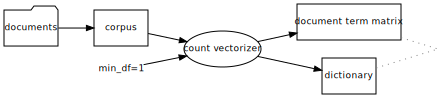

In [5]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; documents;
  node [shape=oval]; vec [label="count vectorizer"];
  node [shape=plain]; min_df [label="min_df=1"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];

  documents -> corpus;
  min_df -> vec;
  corpus -> vec;
  vec -> dtm;
  vec -> dict;
  dtm -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
  dict -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
}
''')


In [6]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix_by_count(series, min_df=1):
    vectorizer = CountVectorizer(min_df=min_df)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary


In [7]:
trivial_document_term_matrix, trivial_dictionary = compose_document_term_matrix_by_count(trivial_corpus['body'])
trivial_document_term_matrix


,brown,dog,fox,lazy,quick,red,slow,the,yellow
the quick brown fox,1,0,1,0,1,0,0,1,0
the slow brown dog,1,1,0,0,0,0,1,1,0
the quick red dog,0,1,0,0,1,1,0,1,0
the lazy yellow fox,0,0,1,1,0,0,0,1,1


### Singular Value Decomposition (SVD)
Singular value decomposition (SVD) encodes our corpus into topic encoded data. Instead of feeding it our text corpus, SVD relies on the document-term matrix produced by the count vectorizer above. We use the text corpus only as index so the resulting Pandas data frame is readable. The algorithm relies on the document-term matrix alone.

To make it easier to determine what a topic is about, the LSA function below also returns a encoding matrix based on the dictionary from the count vectorizer.

Using the same, trivial corpus nicely shows a distinction between the documents talking about dogs (shown as "topic 0") and foxes (as "topic 1").


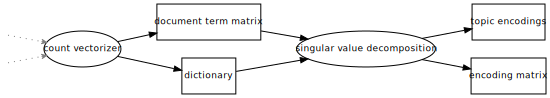

In [8]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=plain label=" "]; dot0; dot1;
  node [shape=oval]; vec [label="count vectorizer"]; svd [label="singular value decomposition"];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"]; topic_enc [label="topic encodings"];
    enc_mtx [label="encoding matrix"];

  dot0 -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  dot1 -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  vec -> dtm;
  vec -> dict;
  dtm -> svd;
  dict -> svd;
  svd -> topic_enc;
  svd -> enc_mtx;
}
''')


In [9]:
def perform_lsa(dt_matrix, dictionary, n_components=2):
    svd = TruncatedSVD(n_components=n_components)
    lsa = svd.fit_transform(dt_matrix)
    topics = [f"topic {n}" for n in range(lsa.shape[1])]

    return pd.DataFrame(index=dt_matrix.index, data=lsa, columns=topics), \
           pd.DataFrame(index=topics, data=svd.components_, columns=dictionary).T


In [10]:
trivial_topic_encodings, trivial_encoding_matrix = perform_lsa(trivial_document_term_matrix, trivial_dictionary)
trivial_topic_encodings


,topic 0,topic 1
the quick brown fox,1.694905,0.299524
the slow brown dog,1.515851,-0.769110
the quick red dog,1.515851,-0.769110
the lazy yellow fox,1.266186,1.440585


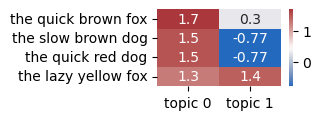

In [11]:
plt.figure(figsize=(2, 1))
sns.heatmap(trivial_topic_encodings, annot=True, cmap=CMAP_VLAG);


In [12]:
trivial_encoding_matrix


,topic 0,topic 1
brown,0.353937,-0.140256
dog,0.334199,-0.459436
fox,0.326416,0.519736
lazy,0.139578,0.430274
quick,0.353937,-0.140256
red,0.167100,-0.229718
slow,0.167100,-0.229718
the,0.660615,0.060300
yellow,0.139578,0.430274


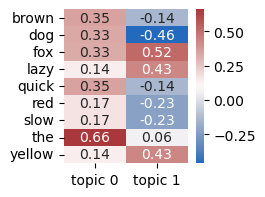

In [13]:
plt.figure(figsize=(2, 2))
sns.heatmap(trivial_encoding_matrix, annot=True, cmap=CMAP_VLAG);


In his code, Joshua takes the absolute values of the topic columns. In his presentation he suggests that we should be looking for the strongest correlations, either negative or positive. Instead of adding columns, we take the absolute value on the fly as we search for the $n$ most significant terms. We don't preserve the absolute values, since they are not needed after selection.

Based on the heatmap above, "topic 1" seems to be based around the type of animal. It has a strong correlation with "fox" and a strong negative correlation with "dog". This is further supported by selecting the most significant terms as shown below.

The stop words are still present. We don't worry about them as they will have been stripped in the data cleaning process of the governance data set.

In [14]:
def n_most_significant(topic, n_terms, encoding_matrix):
    df = encoding_matrix[topic]
    return df.iloc[df.abs().argsort()][::-1][:n_terms].to_frame()

In [15]:
n_most_significant("topic 0", 3, trivial_encoding_matrix)

,topic 0
the,0.660615
quick,0.353937
brown,0.353937


In [16]:
n_most_significant("topic 1", 2, trivial_encoding_matrix)

,topic 1
fox,0.519736
dog,-0.459436


**node**: The scatter plot that Joshua makes relies on the user-supplied classification of the documents. This is an example of supervised input as part of the data validation. Our product owner also spoke of this. We can start doing that once we are working with the whole corpus and have the document type at hand.

XXX: make this plot...

### Use TF-IDF for Stop Word Elimination
Joshua then swaps out the count vectorizer with a TF-IDF vectorizer. We've explored this vectorizer in our previous notebook on TF-IDF already. The TF-IDF vectorizer is a drop-in replacement of the count vectorizer.

Below is the schematic representation of that step, followed by the code and a quick re-run of the visualisation steps.

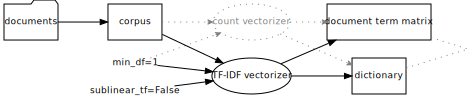

In [17]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; documents;
  node [shape=oval]; vec [label="count vectorizer", color=grey fontcolor=grey style=dotted];
      tfidf [label="TF-IDF vectorizer"];
  node [shape=plain]; min_df [label="min_df=1"]; sublinear_tf [label="sublinear_tf=False"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];

  documents -> corpus;
  corpus -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  corpus -> tfidf;
  sublinear_tf -> tfidf;
  min_df -> tfidf;
  min_df -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  vec -> dtm [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dtm;
  vec -> dict [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dict;
  dtm -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
  dict -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
}
''')

In [18]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix(series, min_df=1, sublinear_tf=False):
    vectorizer = TfidfVectorizer(min_df=min_df, sublinear_tf=sublinear_tf)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary


In [19]:
trivial_document_term_matrix, trivial_dictionary = compose_document_term_matrix(trivial_corpus['body'])
trivial_document_term_matrix


,brown,dog,fox,lazy,quick,red,slow,the,yellow
the quick brown fox,0.539313,0.000000,0.539313,0.000000,0.539313,0.000000,0.000000,0.356966,0.000000
the slow brown dog,0.497096,0.497096,0.000000,0.000000,0.000000,0.000000,0.630504,0.329023,0.000000
the quick red dog,0.000000,0.497096,0.000000,0.000000,0.497096,0.630504,0.000000,0.329023,0.000000
the lazy yellow fox,0.000000,0.000000,0.463458,0.587838,0.000000,0.000000,0.000000,0.306758,0.587838


In [20]:
trivial_topic_encodings, trivial_encoding_matrix = perform_lsa(trivial_document_term_matrix, trivial_dictionary)
trivial_topic_encodings


,topic 0,topic 1
the quick brown fox,0.814343,0.163324
the slow brown dog,0.696636,-0.382803
the quick red dog,0.696636,-0.382803
the lazy yellow fox,0.493787,0.810771


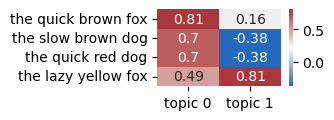

In [21]:
plt.figure(figsize=(2, 1))
sns.heatmap(trivial_topic_encodings, annot=True, cmap=CMAP_VLAG);


---
## Apply LSA to the Governance Data Set
We apply LSA to the subset _duurzaamheidsvisie_ (DV) documents from the governance data set.

### Load the DV Documents from the Governance Data

In [22]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [23]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...
...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...
GM1955DV01,milieuprogramma gemeente Montferland vaststell...
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...
GM1955DV03,energietransitienota duurzaam energie achterho...


In [24]:
corpus.info()


<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, GM0003DV02 to GM1987DV01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    248 non-null    string
dtypes: string(1)
memory usage: 3.9+ KB


In [25]:
document_term_matrix, dictionary = compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=20, sublinear_tf=True)
document_term_matrix


,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbeveling,aanbieden,aanbieder,aanbod,aanbrengen,aandacht,...,zuid,zuinig,zuiveren,zuivering,zullen,zwaar,zwembad,zwerfafval,zwerfvuil,één
GM0003DV02,0.000000,0.012124,0.000000,0.000000,0.038335,0.029930,0.0,0.012347,0.000000,0.030587,...,0.015026,0.032665,0.000000,0.000000,0.037751,0.000000,0.000000,0.000000,0.000000,0.025063
GM0005DV01,0.000000,0.014365,0.000000,0.000000,0.000000,0.012703,0.0,0.000000,0.018393,0.038175,...,0.000000,0.025114,0.000000,0.000000,0.032282,0.000000,0.000000,0.091658,0.000000,0.029696
GM0007DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.017438,0.0,0.000000,0.000000,0.016946,...,0.000000,0.000000,0.000000,0.000000,0.037188,0.015511,0.000000,0.037329,0.049407,0.029497
GM0009DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.017681,0.0,0.034477,0.000000,0.033079,...,0.000000,0.000000,0.000000,0.000000,0.042584,0.000000,0.032561,0.000000,0.000000,0.032031
GM0034DV01,0.000000,0.015203,0.028306,0.000000,0.000000,0.013444,0.0,0.000000,0.000000,0.010540,...,0.000000,0.015698,0.000000,0.031824,0.042473,0.034281,0.000000,0.000000,0.000000,0.036384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.000000,0.022781,0.017774,0.026725,0.000000,0.014293,0.0,0.000000,0.012223,0.015794,...,0.000000,0.016690,0.033432,0.000000,0.023598,0.021526,0.000000,0.000000,0.000000,0.018879
GM1955DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.022675,0.0,0.015423,0.000000,0.027398,...,0.000000,0.000000,0.000000,0.000000,0.035540,0.048129,0.000000,0.000000,0.000000,0.021336
GM1955DV02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.024721,0.000000,0.000000,...,0.000000,0.025064,0.000000,0.000000,0.026504,0.000000,0.000000,0.000000,0.000000,0.034198
GM1955DV03,0.000000,0.000000,0.000000,0.000000,0.082044,0.013232,0.0,0.015238,0.000000,0.027070,...,0.000000,0.000000,0.000000,0.000000,0.025179,0.000000,0.000000,0.000000,0.000000,0.010045


In [26]:
dictionary

array(['aanbested', 'aanbesteding', 'aanbestedingen', ..., 'zwerfafval',
       'zwerfvuil', 'één'], dtype=object)

In [27]:
topic_encodings, encoding_matrix = perform_lsa(document_term_matrix, dictionary)
topic_encodings


,topic 0,topic 1
GM0003DV02,0.644606,-0.072878
GM0005DV01,0.589440,0.342903
GM0007DV01,0.616076,0.350466
GM0009DV01,0.558262,-0.120554
GM0034DV01,0.559517,-0.041792
...,...,...
GM1945DV01,0.673631,-0.007067
GM1955DV01,0.546184,0.338571
GM1955DV02,0.506199,-0.111350
GM1955DV03,0.581925,-0.088893


In [28]:
encoding_matrix

,topic 0,topic 1
aanbested,0.012145,-0.008228
aanbesteding,0.021067,0.004079
aanbestedingen,0.007850,-0.000177
aanbestedingsbeleid,0.009764,-0.006081
aanbeveling,0.013361,0.003194
...,...,...
zwaar,0.012830,0.019075
zwembad,0.011285,-0.007013
zwerfafval,0.017170,0.046042
zwerfvuil,0.006554,0.021511


In [29]:
n_most_significant("topic 0", 20, encoding_matrix)

,topic 0
gemeente,0.081168
duurzaam,0.077180
energie,0.066827
maken,0.060459
duurzaamheid,0.060236
bedrijf,0.058887
project,0.058294
zullen,0.057182
gaan,0.057122
jaar,0.056995


In [30]:
n_most_significant("topic 1", 20, encoding_matrix)

,topic 1
gevaarlijk,0.101641
geluid,0.092557
veiligheid,0.087605
melding,0.087298
milieutak,0.082935
bodemkwaliteit,0.080198
omgevingsvergunning,0.079572
milieubeleidsplan,0.077136
wabo,0.077112
milieubeleid,0.076471


### Determine the correct number of topics using latent sementic analysis
Method 1 Explained variance based on https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis

In [31]:
performance = []
test = range(1, document_term_matrix.shape[1], 2)

for n in test:
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit(document_term_matrix)
    performance.append(lsa.explained_variance_ratio_.sum())

(1.0, 400.0)

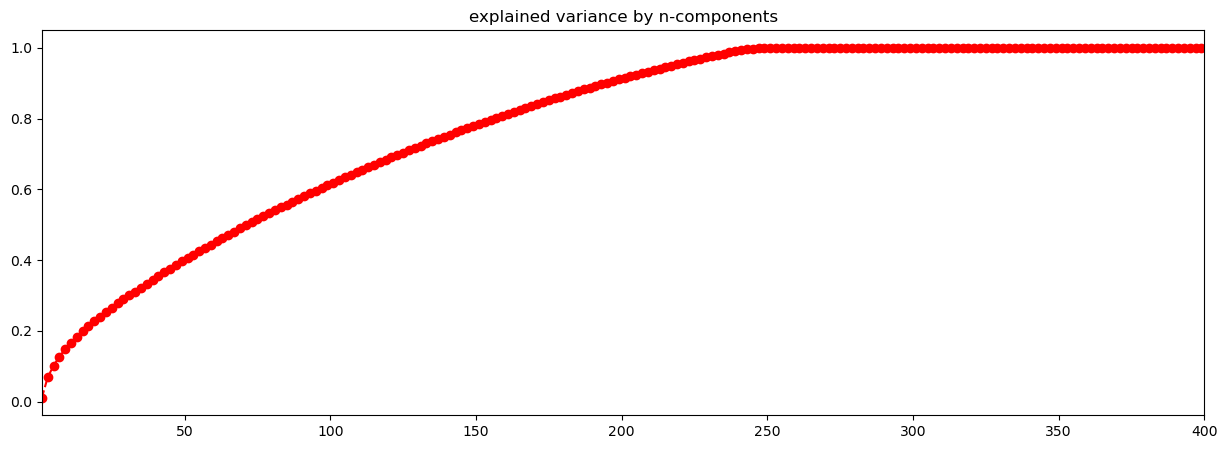

In [32]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('cummunlative explained variance ratio by n-components')
plt.xlim(1, 255)

70 to 80% of the explained variance ratio is reached with 125 to 150 topics.

(0.0, 25.0)

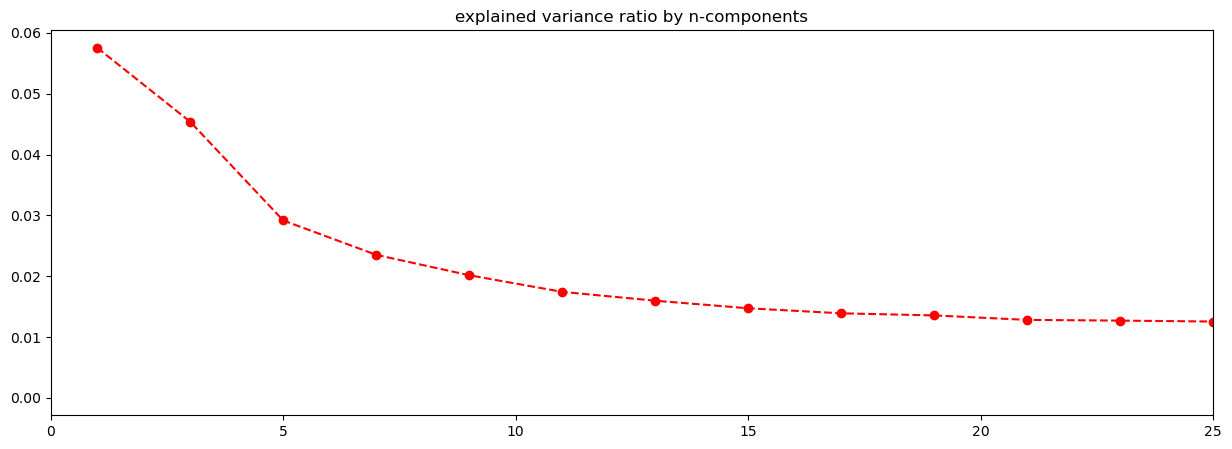

In [35]:
import numpy as np
fig = plt.figure(figsize=(15, 5))
plt.plot(test, np.gradient(performance), 'ro--')
plt.title('explained variance ratio by n-components')
plt.xlim(0, 25) # zoom to 25 to see the changes in the first components

The explained variance ratio of each component flattens around 5 topics.

(0.0, 255.0)

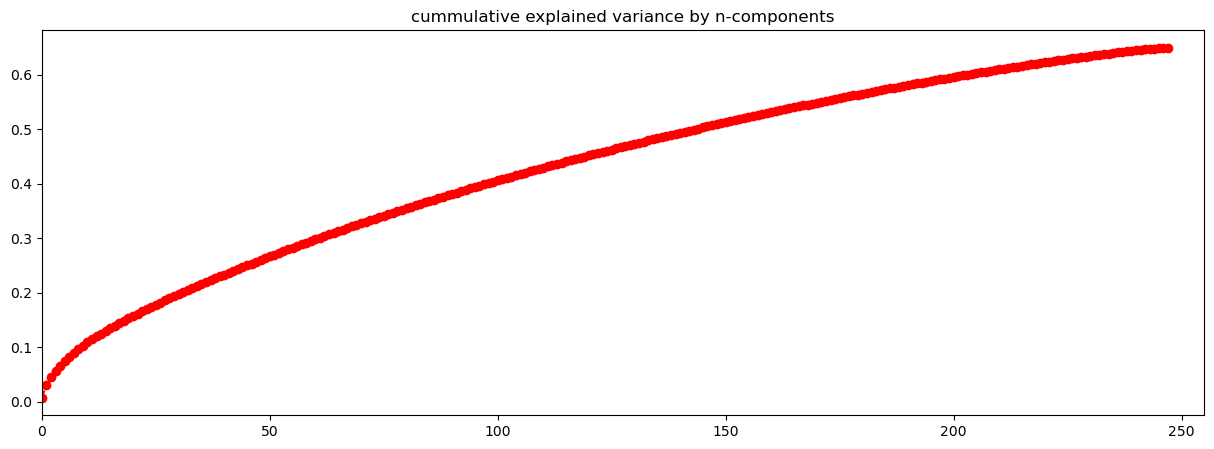

In [36]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(0, len(lsa.explained_variance_)), lsa.explained_variance_.cumsum(), 'ro--')
plt.title('cummulative explained variance by n-components')
plt.xlim(0, 255) 

The graph shows that the explained variance of the LSA model is about 60% at maximum of 253 topics (= number of documents). This low explained variance is probably due to the relative few but lengthy documents.

(0.0, 25.0)

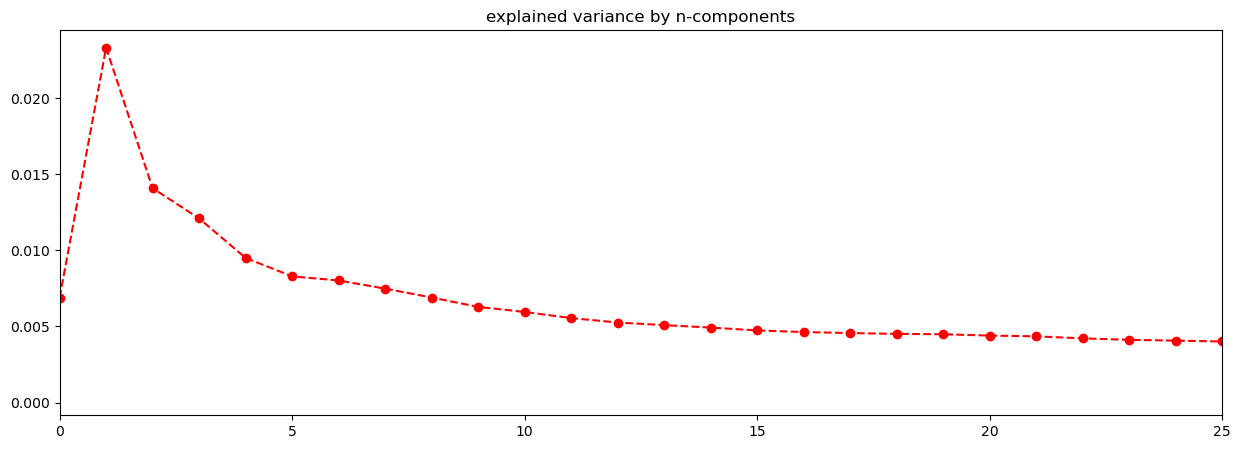

In [37]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(0, len(lsa.explained_variance_)), lsa.explained_variance_, 'ro--')
plt.title('explained variance by n-components')
plt.xlim(0, 25) # zoom to 25 to see the changes in the first components

The explained variance of each component flattens around 5. The first component contributes less to the explained variance, this is typical for LSA. 

Method 2 based on https://www.datacamp.com/tutorial/discovering-hidden-topics-python.
The problem with this method is that it's based on Gensim dictionary and we are using sklearn for our LSA.
Soulution, we implement it ourselves based on https://stackoverflow.com/questions/69730428/how-do-i-find-coherence-score-for-lsa-and-lda-for-sklearn-models

In [33]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1] # Ik heb de indruk dat we hier nog iets aan moeten passen.
            j = topic_top[j_index][1] # Ik heb de indruk dat we hier nog iets aan moeten passen.
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [34]:
for n_topics in range(5, 1000, 50):
    svd = TruncatedSVD(n_components=n_topics, n_iter=7, random_state=42)
    svd.fit(document_term_matrix) # tfid_matrix aangepast naar document_term_matrix
    avg_coherence = get_average_topic_coherence(document_term_matrix, svd.components_, 10) ## tfid_matrix aangepast naar document_term_matrix
    print(str(n_topics) + " " + str(avg_coherence))

InvalidIndexError: (slice(None, None, None), 1212)

### Deze krijg ik nog niet werkend.

### Topic assessment with 5 topics
According to the elbow method 5 topics are optimal to assess the information in the documents. Below these 5 topics are assessed for their content and value for clustering.

In [38]:
svd_dv = TruncatedSVD(n_components=5)
lsa_dv = svd_dv.fit(document_term_matrix)
lsa_docs = svd_dv.fit_transform(document_term_matrix)
lsa_dv.explained_variance_.sum()

0.06586269630855086

The first 5 topics only account for 6.6% of the explained variance between the documents.
The first 5 topics are labelled as respectively "duurzaamheid", "milieu", "ecologie", "energie" and "klimaat" according to the most important words in the topic.

In [39]:
topic_names = ["duurzaamheid","milieu","ecologie","energie","klimaat"]
encoded_matrix = pd.DataFrame(lsa_dv.components_, index=topic_names, columns=dictionary).T
encoded_matrix.sort_values("duurzaamheid", ascending=False) #change the column name to sort by the other topics

,duurzaamheid,milieu,ecologie,energie,klimaat
gemeente,0.081168,-0.042850,-0.030987,-0.122747,-0.018587
duurzaam,0.077180,-0.066738,-0.013914,-0.103622,-0.043827
energie,0.066827,-0.060318,-0.045981,-0.054404,-0.024382
maken,0.060459,-0.030177,-0.006143,-0.067821,-0.006898
duurzaamheid,0.060236,-0.054472,0.019549,-0.110894,-0.025924
...,...,...,...,...,...
meehelpen,0.003940,-0.005111,0.008449,-0.003068,-0.000468
versnippering,0.003939,0.008855,0.007091,0.003751,-0.001435
andersom,0.003851,-0.000793,0.012757,0.004196,-0.000450
verbieden,0.003840,0.018074,0.000850,0.000192,0.000939


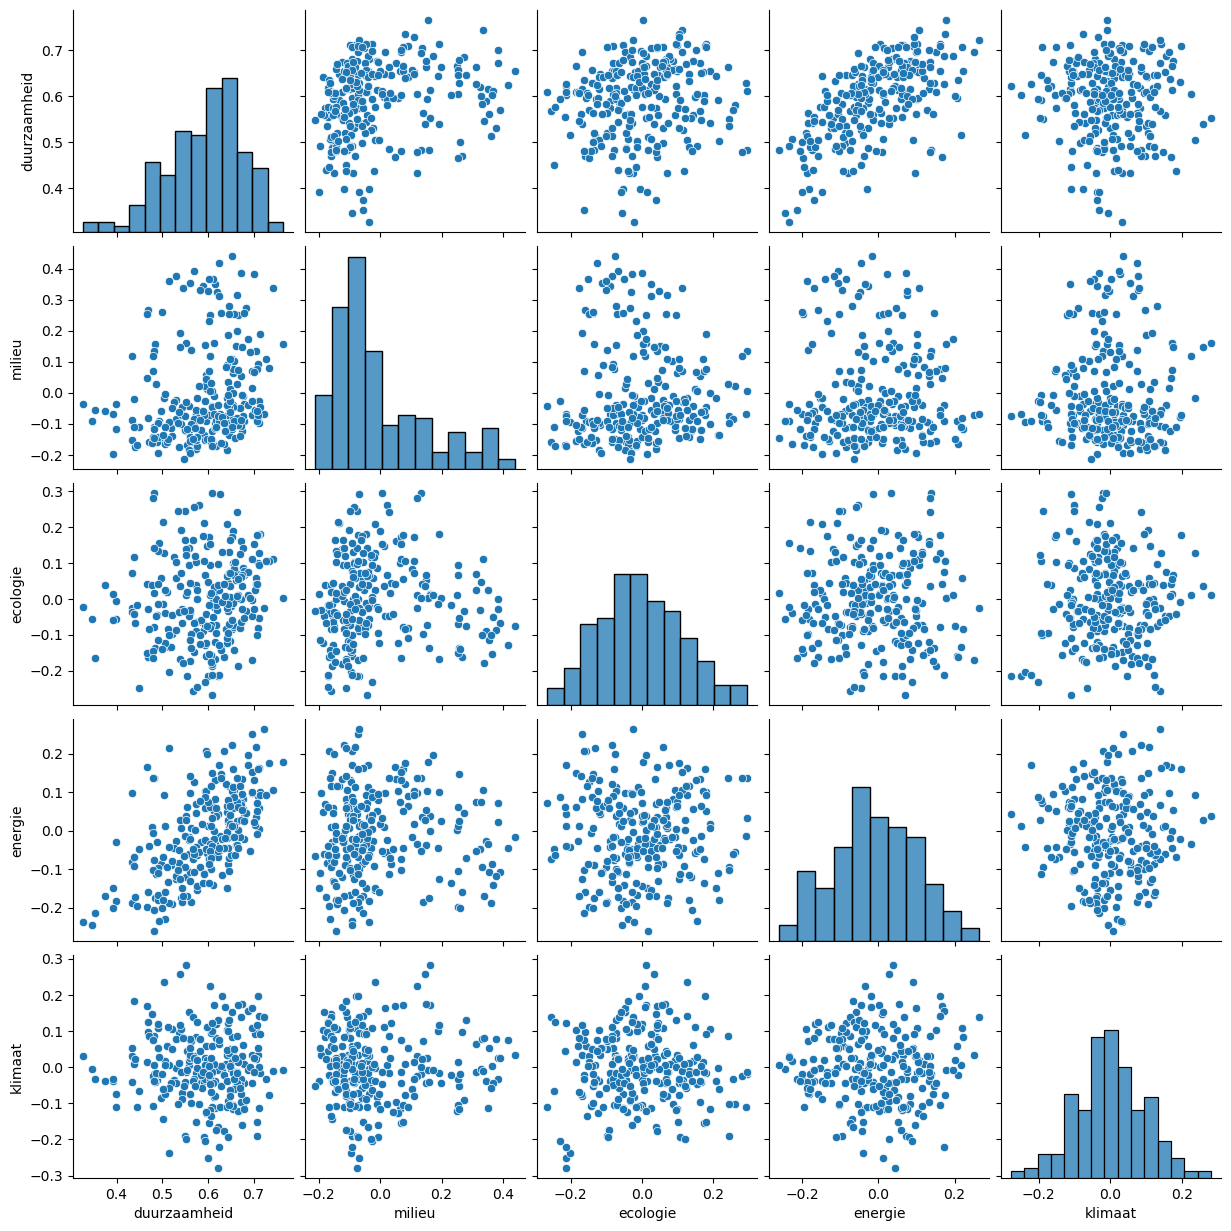

In [40]:
topics_encoded = pd.DataFrame(lsa_docs, columns=topic_names, index=corpus.index)
sns.pairplot(topics_encoded)

The first 5 topics don't show direct recognisable clusters. Most documents are pretty low on the 'milieu' topic, which indicates this topic is less mentioned in the sustainability visions. 'Energie' correlates with the first 'duurzaamheid' topic, indicating that most sustainability visions contain energy related terms.